# Exercise 4

Basics of Deep Learning & Convolutional Neural
Network

1. Play with a defined Convolutional Neural Network (CNN) on MNIST dataset which
available at google colab. Visualize the feature maps generated by the initial three layers:
• Conv2D
• AvgPooling2D
• Conv2D
Include an analysis of feature maps from various layers in your report

In [1]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
torch.cuda.is_available()

True

In [31]:
# Adapted from https://github.com/pytorch/examples/blob/main/mnist/main.py

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [105]:
args = argparse.Namespace(
    batch_size = 64,
    test_batch_size=128,
    epochs=3,
    lr=1e-1,
    gamma=.7,
    dry_run=False,
    seed=42,
    log_interval=50,
    save_model=False,    
)

In [139]:
torch.manual_seed(args.seed)
use_cuda = torch.cuda.is_available()
if use_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

train_kwargs = {'batch_size': args.batch_size}
test_kwargs = {'batch_size': args.test_batch_size}
if use_cuda:
    cuda_kwargs = {'num_workers': 4,
                    'pin_memory': True,
                    'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(degrees=20),
    transforms.RandomResizedCrop(size=(28, 28), antialias=True),
    transforms.Normalize((0.1307,), (0.3081,)),
])

transform_test=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])
dataset1 = datasets.MNIST('../data', train=True, download=True,
                    transform=transform)
dataset2 = datasets.MNIST('../data', train=False,
                    transform=transform_test)

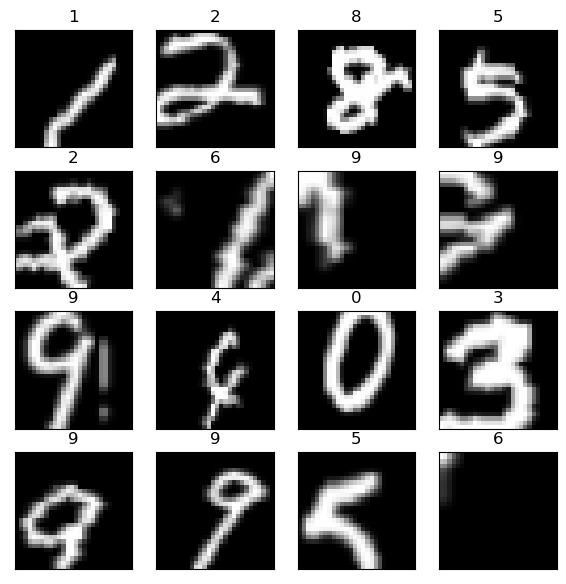

In [140]:
import matplotlib.pyplot as plt

train_loader = torch.utils.data.DataLoader(dataset1, **train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

for batch_idx, (data, target) in enumerate(train_loader):
    fig, axes = plt.subplots(4,4, figsize=(7,7))
    for img, target, ax in zip(data, target, axes.ravel()):
        ax.imshow(img.squeeze(), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(target.item())
    break

In [141]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.bn = nn.BatchNorm2d(num_features=1)
        self.conv1 = nn.Conv2d(1, 8, 3, 1)
        self.conv2 = nn.Conv2d(8, 32, 3, 1)
        self.conv3 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.fc1 = nn.Linear(7744, 128)
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.bn(x)
        
        for convN in [self.conv1, self.conv2, self.conv3]:
            x = convN(x)
            x = F.relu(x)
        
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output



def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if args.dry_run:
                break

model = Net().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=args.lr)

scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)
for epoch in range(1, args.epochs + 1):
    train(args, model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.299240
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.313387
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.212878
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.052361
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.033471
Train Epoch: 1 [16000/60000 (27%)]	Loss: 1.943147
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.689901
Train Epoch: 1 [22400/60000 (37%)]	Loss: 1.629320
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.852932
Train Epoch: 1 [28800/60000 (48%)]	Loss: 1.654154
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.575266
Train Epoch: 1 [35200/60000 (59%)]	Loss: 1.702195
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.453769
Train Epoch: 1 [41600/60000 (69%)]	Loss: 1.593837
Train Epoch: 1 [44800/60000 (75%)]	Loss: 1.320798
Train Epoch: 1 [48000/60000 (80%)]	Loss: 1.334061
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.300189
Train Epoch: 1 [54400/60000 (91%)]	Loss: 1.483921
Train Epoch: 1 [57600/60000 (96%)]	Loss: 1.292823

Test set: Average loss: 0.2332, Accuracy: 9454/10000 (95%)

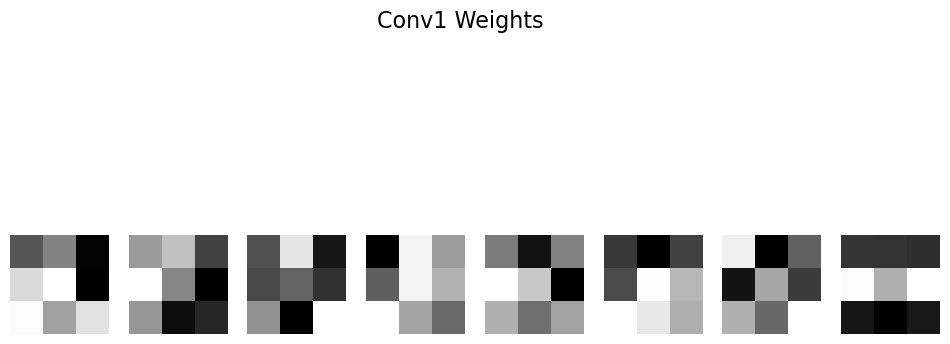

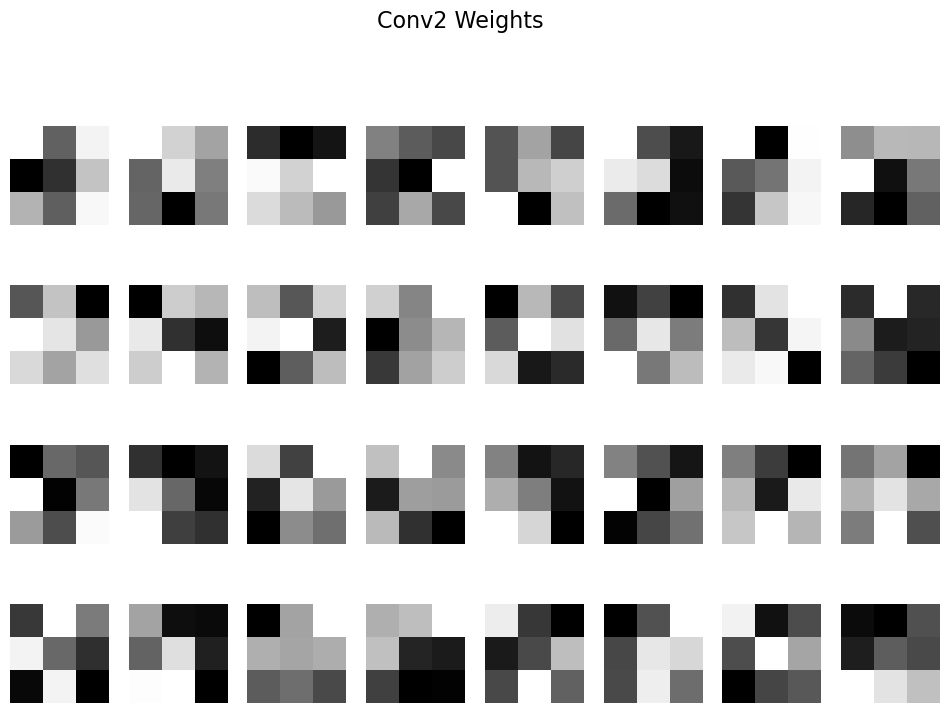

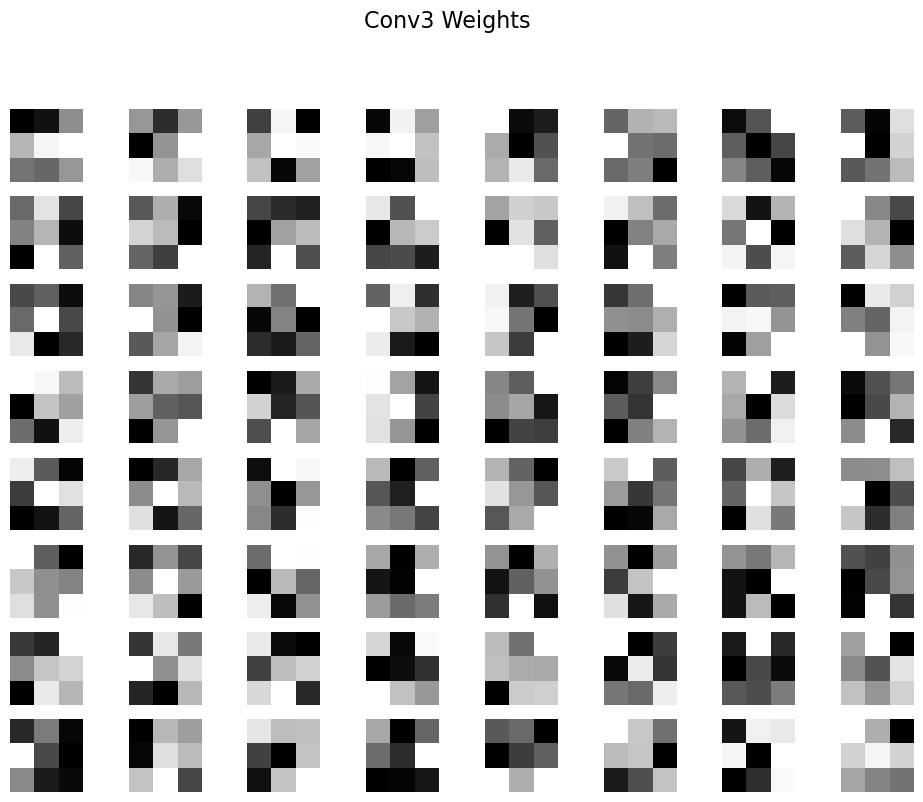

In [142]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot the weights of the convolutional layers
def plot_conv_weights(weights, layer_name):
    num_filters = weights.shape[0]
    num_cols = 8
    num_rows = num_filters // num_cols + 1

    plt.figure(figsize=(12, 10))
    plt.suptitle(f'{layer_name} Weights', fontsize=16)

    for i in range(num_filters):
        plt.subplot(num_rows, num_cols, i+1)
        plt.imshow(weights[i, 0, :, :].detach().cpu().numpy(), cmap='gray')
        plt.axis('off')

    plt.show()

# Get the weights of the first two convolutional layers
conv1_weights = model.conv1.weight.data
conv2_weights = model.conv2.weight.data
conv3_weights = model.conv3.weight.data

# Plot the weights
plot_conv_weights(conv1_weights, 'Conv1')
plot_conv_weights(conv2_weights, 'Conv2')
plot_conv_weights(conv3_weights, 'Conv3')

In [143]:
# Get the first batch from the train_loader
data_iter = iter(train_loader)
images, labels = next(data_iter)
sample_image = images[0:1]

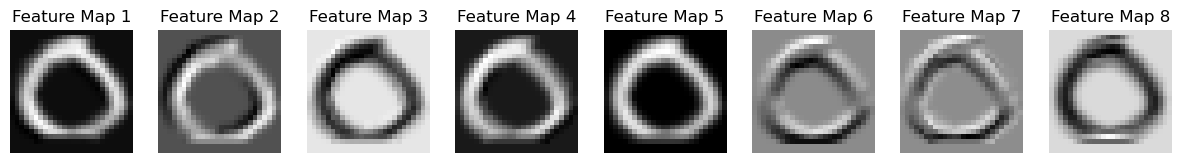

In [144]:
import torch

# Function to register hook for extracting feature maps
def get_interested_feature_maps(module, input, output):
    global feature_maps
    feature_maps = output.detach().cpu()

# Register the hook to the second convolutional layer
hook_layer = model.conv1.register_forward_hook(get_interested_feature_maps)

# Set the model to evaluation mode
model.eval()

# Forward pass to get the feature maps
with torch.no_grad():
    model(sample_image.to(device))

# Remove the hook
hook_layer.remove()

# Visualize the feature maps in a square grid
num_feature_maps = feature_maps.shape[1]
side = max(int(np.sqrt(num_feature_maps)),8)
plt.figure(figsize=(15, 15))
for i in range(num_feature_maps):
    plt.subplot(side, side, i + 1)
    plt.imshow(feature_maps[0, i, :, :].numpy(), cmap='gray')
    plt.axis('off')
    plt.title(f'Feature Map {i + 1}')

plt.show()


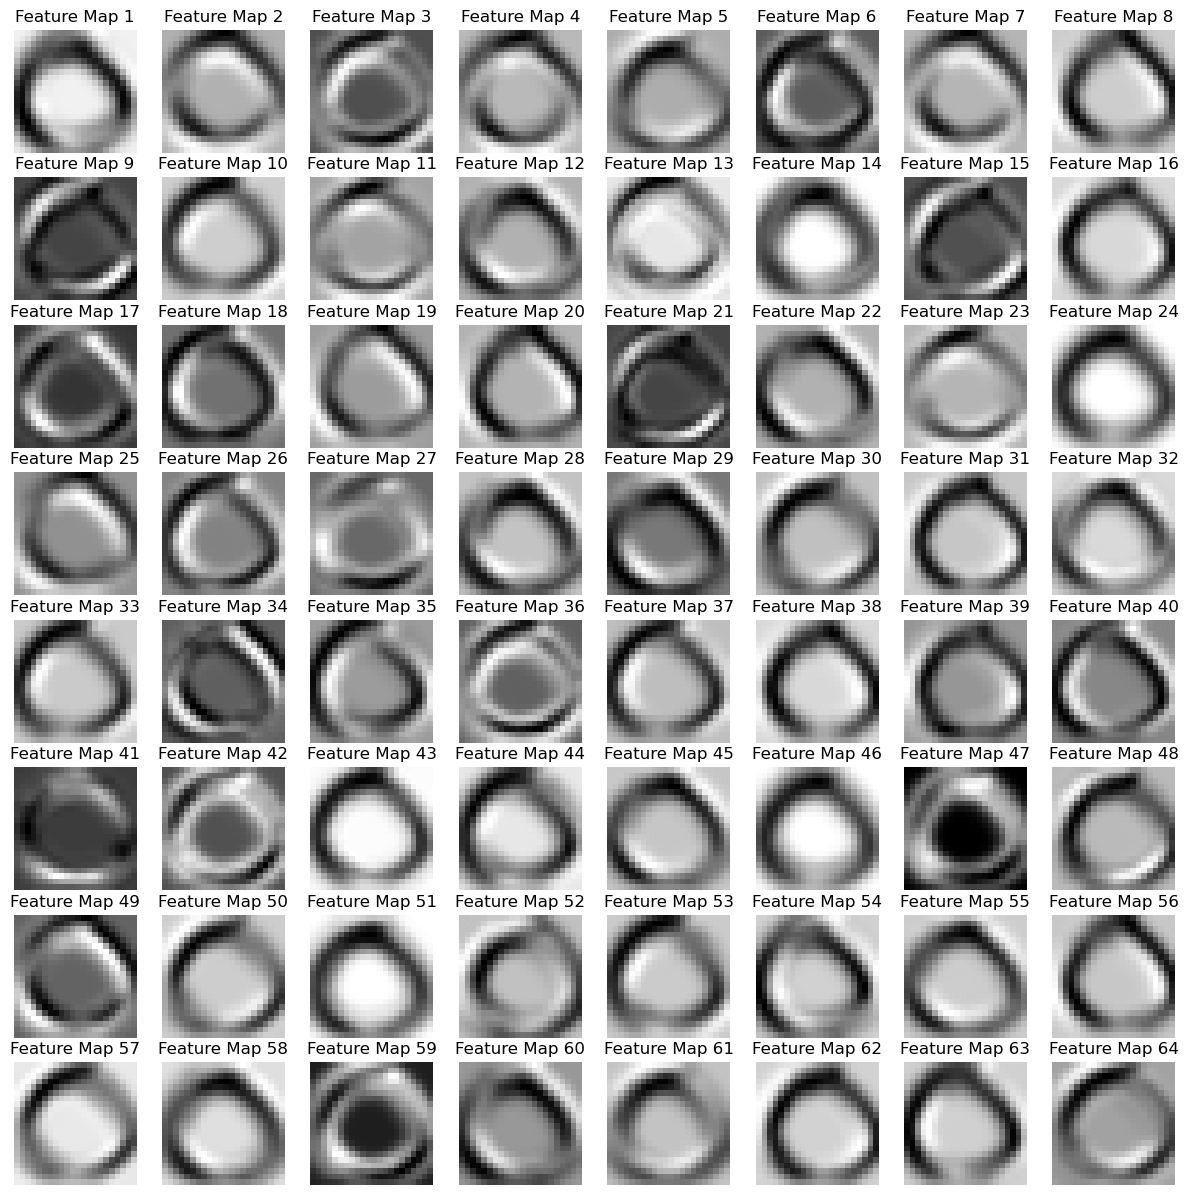

In [145]:
def get_interested_feature_maps(module, input, output):
    global feature_maps
    feature_maps = output.detach().cpu()

# Register the hook to the second convolutional layer
hook_layer = model.conv3.register_forward_hook(get_interested_feature_maps)

# Set the model to evaluation mode
model.eval()

# Forward pass to get the feature maps
with torch.no_grad():
    model(sample_image.to(device))

# Remove the hook
hook_layer.remove()

# Visualize the feature maps in a square grid
num_feature_maps = feature_maps.shape[1]
side = max(int(np.sqrt(num_feature_maps)),8)
plt.figure(figsize=(15, 15))
for i in range(num_feature_maps):
    plt.subplot(side, side, i + 1)
    plt.imshow(feature_maps[0, i, :, :].numpy(), cmap='gray')
    plt.axis('off')
    plt.title(f'Feature Map {i + 1}')

plt.show()


tensor(-0.0499) tensor(1.0289)


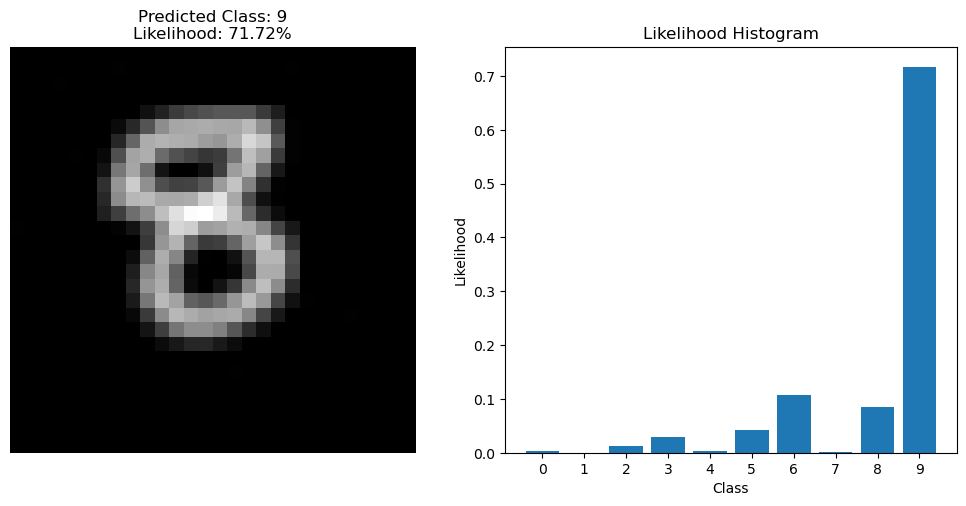

tensor(0.0045) tensor(1.0652)


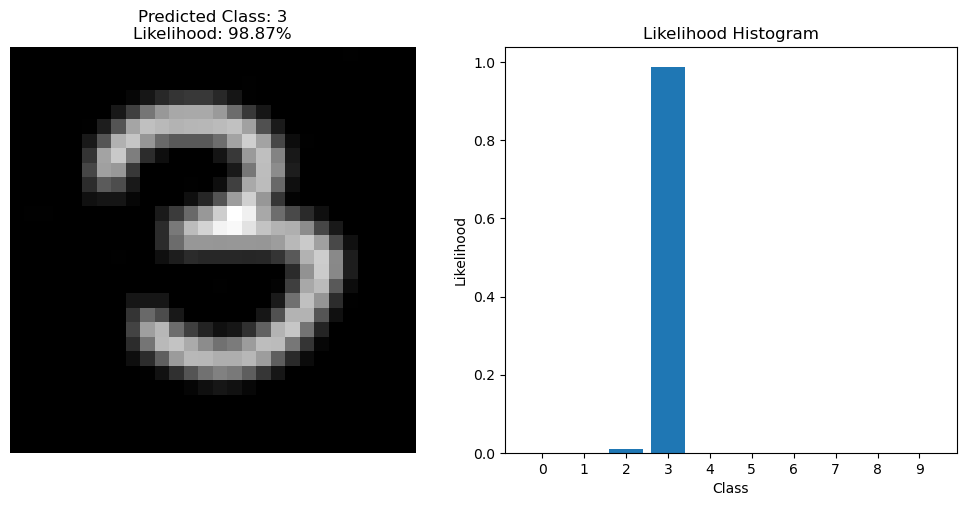

tensor(-0.0884) tensor(0.9886)


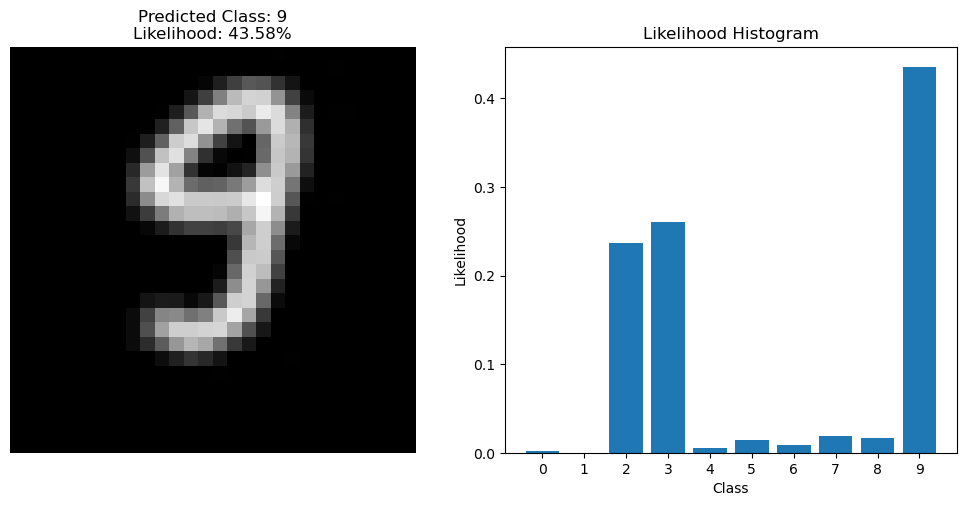

tensor(0.0084) tensor(1.0708)


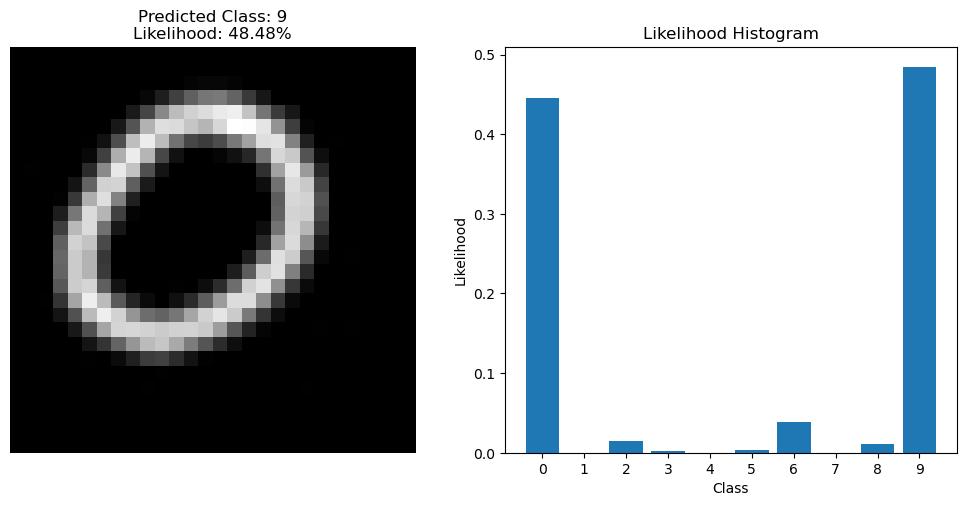

tensor(-0.1105) tensor(0.9824)


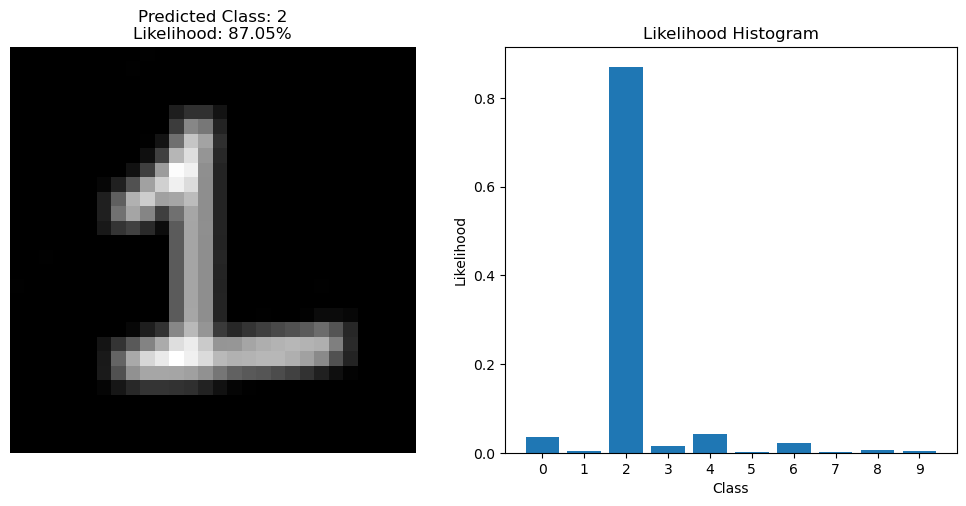

In [146]:
import glob

# Directory containing digit images
image_directory = 'my_handwriting/'

# Find all digit image files in the directory
image_files = glob.glob(image_directory + '*.jpg')

# Set the model to evaluation mode
model.eval()

transform_2 = transforms.Compose([
    transforms.PILToTensor(),
    transforms.Lambda(lambda x: x / 255),
    transforms.Normalize((0.09,), (0.17,))
])
# Plot for each image file
for image_path in image_files:
    
    # Load the image
    handwriting_image = Image.open(image_path).convert('L')  # Convert to grayscale

    # Apply transformations
    img = transform_2(handwriting_image).unsqueeze(0)  # Add batch dimension
    print(img.mean(), img.std())
    # Perform inference
    with torch.no_grad():
        img = img.to(device)
        output = model(img).to('cpu').detach()

    # Get the predicted class and likelihood
    predicted_class = torch.argmax(output).item()
    likelihood = torch.exp(output[:, predicted_class]).item()

    # Plot the image and likelihood histogram
    plt.figure(figsize=(10, 5))

    # Plot the image
    plt.subplot(1, 2, 1)
    plt.imshow(handwriting_image, cmap='gray')
    plt.title(f'Predicted Class: {predicted_class}\nLikelihood: {likelihood:.2%}')
    plt.axis('off')

    # Plot the likelihood histogram
    plt.subplot(1, 2, 2)
    plt.bar(range(10), torch.exp(output).squeeze().numpy())
    plt.xticks(range(10), [str(i) for i in range(10)])
    plt.title('Likelihood Histogram')
    plt.xlabel('Class')
    plt.ylabel('Likelihood')

    plt.tight_layout()
    plt.show()

Results:
    
Tests on my own handwriting resulted in a large accuracy drop. This is likely caused by a so-called train-test skew, which means that small differences between input pixels (their values, neigbors, etc), cause significant issues when taken together.

Some common skew issues are:
- Handwritten images are not scaled the same way as the train/test data (i.e. 0-1, or std scale)
- Handwritten images contain larger or smaller pictures
- Handwritten images are blurry, or somehow corrupted

I've tried amending all these, but accuracy is still poor. One thing that did help, however, was adding image agumentations to the training pipeline at the start of the model training. This helped label a few of my handwriting samples correctly.

About HyperParam tuning:

For the given architecture, without image augmentations, the parameter tuning doesn't do much, as we can readily exceed 98% test accuracy even on the first epoch. With image augmentation, if the test-set isn't augmented, we still reach 98% accuracy by the end of the first epoch.

Otherwise, the test-accuracy drops to 60-70%, while the overall real-world performance improves.

Additionally, given that Adam and other 2d order optimizers aren't too sensitive to initial learning rates, changing learning rate doesn't change much.



## CIFAR100 

In [149]:
# Adapted from https://github.com/weiaicunzai/pytorch-cifar100/
from torch.utils.data import DataLoader
import torchvision

def get_training_dataloader(mean, std, batch_size=16, num_workers=2, shuffle=True):
    transform_train = transforms.Compose([
        #transforms.ToPILImage(),
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
    #cifar100_training = CIFAR100Train(path, transform=transform_train)
    cifar100_training = torchvision.datasets.CIFAR100(root='../data', train=True, download=True, transform=transform_train)
    cifar100_training_loader = DataLoader(
        cifar100_training, shuffle=shuffle, num_workers=num_workers, batch_size=batch_size)

    return cifar100_training_loader


def get_test_dataloader(mean, std, batch_size=16, num_workers=2, shuffle=True):
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
    #cifar100_test = CIFAR100Test(path, transform=transform_test)
    cifar100_test = torchvision.datasets.CIFAR100(root='../data', train=False, download=True, transform=transform_test)
    cifar100_test_loader = DataLoader(
        cifar100_test, shuffle=shuffle, num_workers=num_workers, batch_size=batch_size)

    return cifar100_test_loader

In [164]:
CIFAR100_TRAIN_MEAN = (0.5070751592371323, 0.48654887331495095, 0.4409178433670343)
CIFAR100_TRAIN_STD = (0.2673342858792401, 0.2564384629170883, 0.27615047132568404)

cifar100_training_loader = get_training_dataloader(
    CIFAR100_TRAIN_MEAN,
    CIFAR100_TRAIN_STD,
    num_workers=128,
    batch_size=64,
    shuffle=True
)

cifar100_test_loader = get_test_dataloader(
    CIFAR100_TRAIN_MEAN,
    CIFAR100_TRAIN_STD,
    num_workers=4,
    batch_size=128,
    shuffle=True
)

Files already downloaded and verified
Files already downloaded and verified


In [153]:
# From  https://arxiv.org/abs/1512.03385v1

import torch
import torch.nn as nn

class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        #residual function
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * BasicBlock.expansion, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels * BasicBlock.expansion)
        )

        #shortcut
        self.shortcut = nn.Sequential()

        #the shortcut output dimension is not the same with residual function
        #use 1*1 convolution to match the dimension
        if stride != 1 or in_channels != BasicBlock.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * BasicBlock.expansion)
            )

    def forward(self, x):
        return nn.ReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))

class BottleNeck(nn.Module):
    """
    Residual block for resnet over 50 layers
    """
    expansion = 4
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, stride=stride, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * BottleNeck.expansion, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels * BottleNeck.expansion),
        )

        self.shortcut = nn.Sequential()

        if stride != 1 or in_channels != out_channels * BottleNeck.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BottleNeck.expansion, stride=stride, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_channels * BottleNeck.expansion)
            )

    def forward(self, x):
        return nn.ReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))

class ResNet(nn.Module):

    def __init__(self, block, num_block, num_classes=100):
        super().__init__()

        self.in_channels = 64

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True))
        #we use a different inputsize than the original paper
        #so conv2_x's stride is 1
        self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(block, 128, num_block[1], 2)
        self.conv4_x = self._make_layer(block, 256, num_block[2], 2)
        self.conv5_x = self._make_layer(block, 512, num_block[3], 2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        """make resnet layers(by layer i didnt mean this 'layer' was the
        same as a neuron netowork layer, ex. conv layer), one layer may
        contain more than one residual block

        Args:
            block: block type, basic block or bottle neck block
            out_channels: output depth channel number of this layer
            num_blocks: how many blocks per layer
            stride: the stride of the first block of this layer

        Return:
            return a resnet layer
        """

        # we have num_block blocks per layer, the first block
        # could be 1 or 2, other blocks would always be 1
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        output = self.conv1(x)
        output = self.conv2_x(output)
        output = self.conv3_x(output)
        output = self.conv4_x(output)
        output = self.conv5_x(output)
        output = self.avg_pool(output)
        output = output.view(output.size(0), -1)
        output = self.fc(output)

        return output

def resnet18():
    """ return a ResNet 18 object
    """
    return ResNet(BasicBlock, [2, 2, 2, 2])

def resnet34():
    """ return a ResNet 34 object
    """
    return ResNet(BasicBlock, [3, 4, 6, 3])

def resnet50():
    """ return a ResNet 50 object
    """
    return ResNet(BottleNeck, [3, 4, 6, 3])

def resnet101():
    """ return a ResNet 101 object
    """
    return ResNet(BottleNeck, [3, 4, 23, 3])

def resnet152():
    """ return a ResNet 152 object
    """
    return ResNet(BottleNeck, [3, 8, 36, 3])

In [166]:
def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if args.dry_run:
                break

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

model = resnet34().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=1)

args.epochs = 6
scheduler = StepLR(optimizer, step_size=1, gamma=.8)
for epoch in range(1, args.epochs + 1):
    train(args, model, device, cifar100_training_loader, optimizer, epoch)
    test(model, device, cifar100_test_loader)
    scheduler.step()

Train Epoch: 1 [0/50000 (0%)]	Loss: 4.832231
Train Epoch: 1 [3200/50000 (6%)]	Loss: 4.356626
Train Epoch: 1 [6400/50000 (13%)]	Loss: 4.323647
Train Epoch: 1 [9600/50000 (19%)]	Loss: 4.331470
Train Epoch: 1 [12800/50000 (26%)]	Loss: 4.061576
Train Epoch: 1 [16000/50000 (32%)]	Loss: 4.088579
Train Epoch: 1 [19200/50000 (38%)]	Loss: 3.839848
Train Epoch: 1 [22400/50000 (45%)]	Loss: 4.197285
Train Epoch: 1 [25600/50000 (51%)]	Loss: 4.147492
Train Epoch: 1 [28800/50000 (58%)]	Loss: 3.903158
Train Epoch: 1 [32000/50000 (64%)]	Loss: 3.996137
Train Epoch: 1 [35200/50000 (70%)]	Loss: 3.704183
Train Epoch: 1 [38400/50000 (77%)]	Loss: 3.813443
Train Epoch: 1 [41600/50000 (83%)]	Loss: 3.690447
Train Epoch: 1 [44800/50000 (90%)]	Loss: 3.487574
Train Epoch: 1 [48000/50000 (96%)]	Loss: 3.485943

Test set: Average loss: 4.2826, Accuracy: 1003/10000 (10%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 4.037914
Train Epoch: 2 [3200/50000 (6%)]	Loss: 3.597887
Train Epoch: 2 [6400/50000 (13%)]	Loss: 3.696688
Train 

Damnit the training of this beast takes a while... Took around 5 mins for resnet34 for 5 epochs.

For  optimal results, we can see that we need around 300 epochs. I'm not going to wait around for that long :)

Optimal results can be seen [here](https://huggingface.co/edadaltocg/resnet34_cifar100) on huggingface.

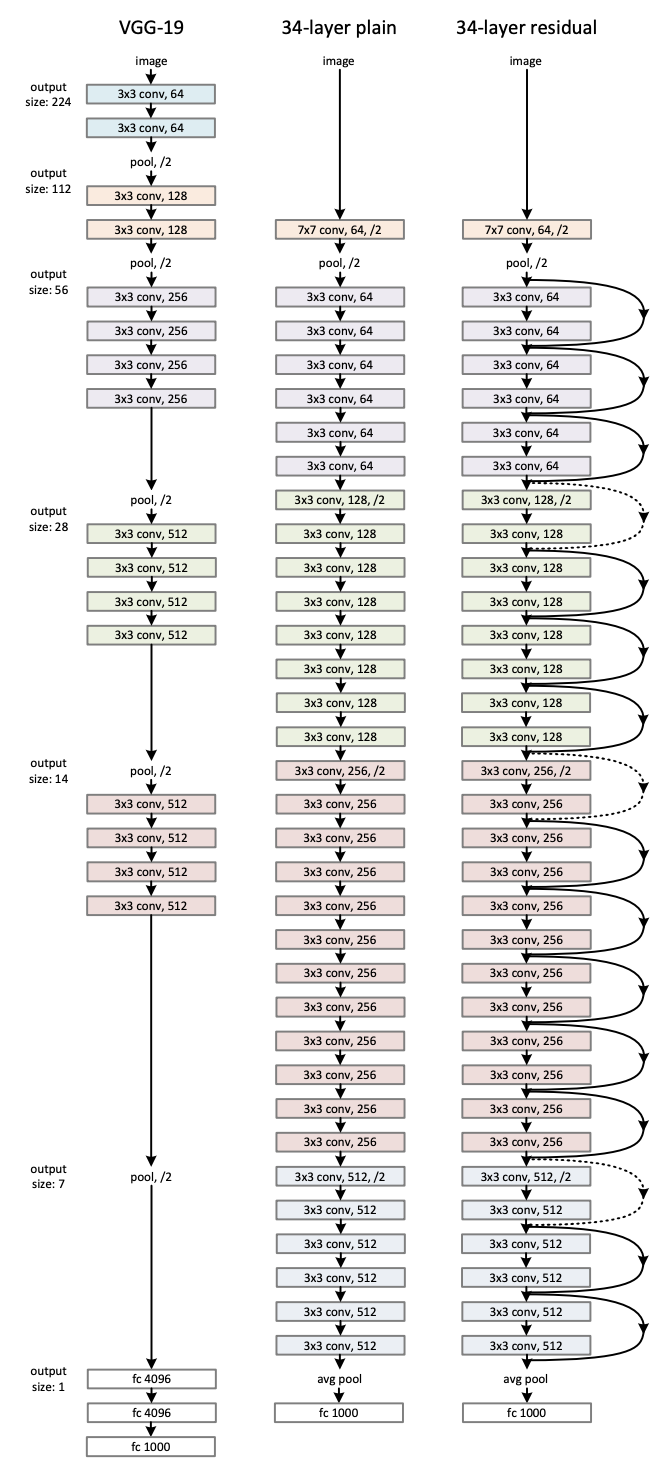